## Building Energy
### Chris Prince (cmp670)
**Using Dr. Bianco's notebook as a template.**

In [1]:
import geopandas as gp
import pandas as pd
import os
import pylab as pl

#I tried a few things to lessen the memory burden, but they did not work.
#import pickle
#mport multiprocessing
#import tables
#import json
#import dbfread
#import zipfile as zf
#s = json.load( open(os.getenv('PUI2015')+'/fbb_matplotlibrc.json') )
#pl.rcParams.update(s)
%pylab inline

#tables.getPyTablesVersion()

Populating the interactive namespace from numpy and matplotlib


I am using geopanda. that is **not required** for this particular exercise, but geopand works with geospacial data: the shape files that we get from pluto for example.

PLEASE REMEMBER: seed your random functions if you need to use any, label your axes clearly, comment your code, use PEP8!


##We will use 2 different datasets.
##an interesting urban question is "can we measure and predict energy use based on observables that are easier to be acquired". for example the urban observatory at CUSP can monitor lights: they are a realtively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.
##so let's test if the last link holds. If we have data on the energy consumed by a __building__ how well does that relate to the number of units in the building?

## data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  

In [2]:
nrg = gp.GeoDataFrame.from_csv('https://data.cityofnewyork.us/resource/m46j-75iy.csv')
    #"Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv


In [3]:
#Let's rename the columns we'll need later on
nrg.rename(columns={'nyc_borough_block_and_lot_bbl': 'BBL',
                    'site_eui_kbtu_ft2': 'kbtu_ft2',
                    'reported_property_floor_area_building_s_ft': 'ft2'}, 
           inplace=True)

In [4]:
#This didn't work either.
#with zf.ZipFile('./data/pluto/mn_mappluto_15v1.zip', 'r') as z:
#    with z.open('Manhattan/MNMapPLUTO.dbf') as d:
#        bsize = dbfread.DBF(d, load=True)

#however this datasets does not have the number of units. We can find that in the Pluto dataset.
reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp

In [5]:
bsize = gp.GeoDataFrame.from_file('/Manhattan/MNMapPLUTO.shp', vfs="zip://./data/pluto/mn_mappluto_15v1.zip")

In [ ]:
#bsize.to_hdf('plutoMN.hdf', 'table')

In [ ]:
#import gc

In [ ]:
#gc.collect()
#gc.garbage

in pandas scatter_matrix will plot each column agains each other. that is a great way to begin inspecting your data (though be careful cause it is computationally comsuming for large datasets) 



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4aa66fe710>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f4aa3afc210>]], dtype=object)

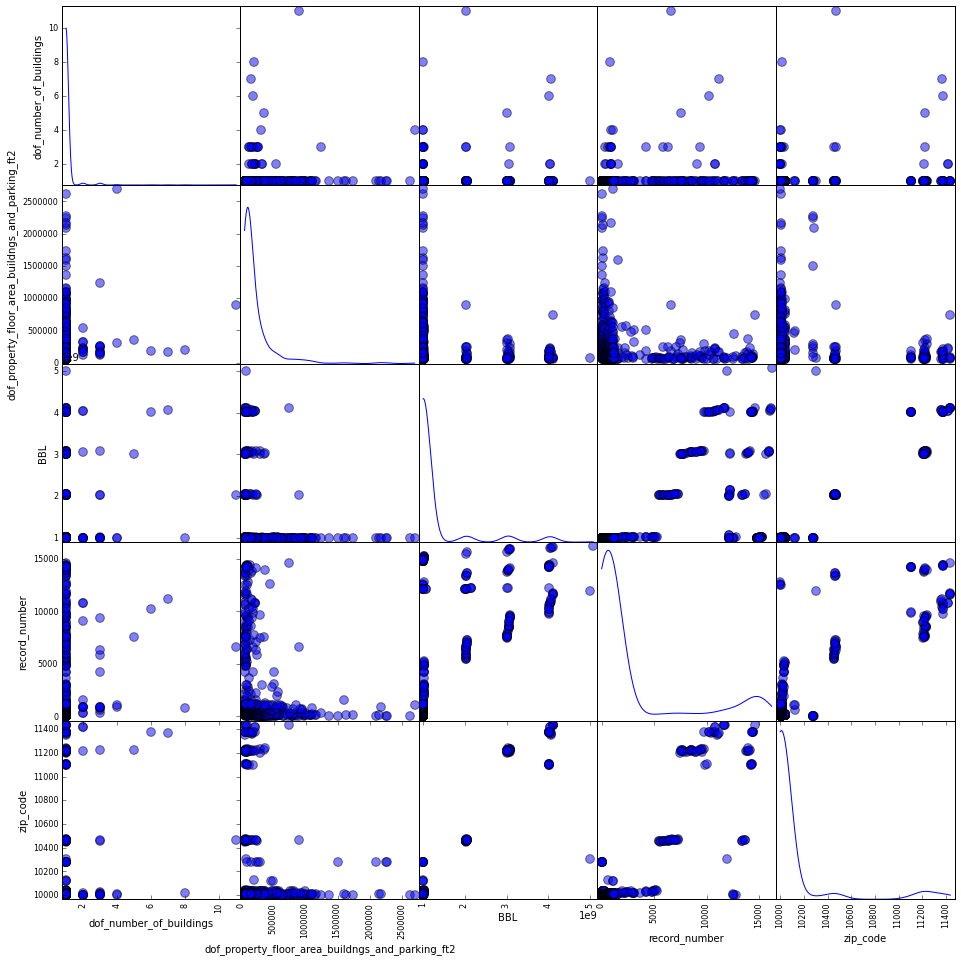

In [6]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg, s=300, figsize=(16, 16), diagonal='kde')

it will show me correlations between variables, but it will also show me what can and 
cannot be plotted trivially in my dataset! here only a few columns can be plotted: 
those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. 
The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg.       u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: i need to remove all values that cannot conver to float in order to use the columns and convert them to float arrays and do math with them. 

Below I created a function that returns True if what is passed as argument can be converted to a float, and False otherwise. I do it with the Try/Except structure. it is a very useful python functionality that you should look into.  
this has to be done entry by entry: if you gve t a series you get error "cannot convert the series to <type 'float'>"

However you can pass it a whole array by using it in conjunction with
np.vectorize (look up the syntax!) which will implement a for loop for you under the hood to pass the series entry by entry to your function.


In [7]:
def canconvert(mydata):
    try :
        float(mydata)
        return True
    except ValueError:
        return False
    

Now for every column i care about i can create an array, call it for eg. indx, of True and False (a Boolean array) that i can use as an index to pick entries that 
I want to use from my arrays of interest. I can replace the entries that failed to be converted to 'NaN'

(because my function return Trues when I can convert and False otherwise i actuallly want the complementary array: ~indx)

In [8]:
#create the indices array here
vcanconvert = np.vectorize(canconvert)

In [9]:
indxE=vcanconvert(nrg['kbtu_ft2'])
indxA=vcanconvert(nrg['ft2'])

Not sure what the difference is between vectorizing this computation and doing a list comprehension. So let's check!

In [10]:
%timeit indx=vcanconvert(nrg['kbtu_ft2'])

1000 loops, best of 3: 748 µs per loop


In [11]:
%timeit iindx=[canconvert(val) for val in nrg['kbtu_ft2']]

1000 loops, best of 3: 724 µs per loop


Not much difference then!

In [12]:
nrg['kbtu_ft2'][~indxE]=float('NaN')
nrg['ft2'][~indxA] = float('NaN')

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [13]:
##check that your conversion worked: e.g.
print nrg.kbtu_ft2.astype(float)
print nrg.ft2.astype(float)
#Nan's are ok, but you must not get an error when you try the conversion
#the Pluto data is much better at not using spurious entries for numerical value columns. 
#but check you can use the columns you want
print bsize.BBL.astype(float)
#notice i can use the attribute notation to refer to columns in bsize, 
#cause the column names do not have spaces!

automatic_water_benchmarking_eligible
NaN      NaN
Yes      NaN
NaN      NaN
No       NaN
NaN      NaN
NaN      NaN
No       NaN
NaN      NaN
Yes      NaN
NaN      NaN
Yes      NaN
Yes      NaN
No       NaN
No       NaN
NaN      NaN
No       NaN
No     125.4
No       NaN
NaN      NaN
Yes      NaN
Yes      NaN
Yes      NaN
Yes      NaN
NaN      NaN
No       NaN
NaN      NaN
NaN      NaN
No       NaN
NaN      NaN
NaN      NaN
       ...  
No      43.9
No      49.5
Yes      NaN
No      90.7
Yes     88.6
No      69.4
NaN     95.6
No     114.0
No       NaN
Yes     84.0
No      11.4
No      55.4
No      89.6
No      84.6
Yes     74.3
No       NaN
Yes      NaN
Yes      NaN
Yes      NaN
No       NaN
No       NaN
Yes      NaN
No      91.4
Yes      2.6
Yes     63.2
No      92.4
No      38.9
Yes      NaN
Yes    107.8
No       NaN
Name: kbtu_ft2, dtype: float64
automatic_water_benchmarking_eligible
NaN    918919
Yes       NaN
NaN     64200
No        NaN
NaN     50000
NaN     61800
No     102198
Na

#TO MERGE THE DATASET WE NEED A COMMON COLUMN
here is where you want to merge the datasets. You need a common column: the building id BBL
However the name of this variable (column) in the Energy dataset is     'NYC Borough, Block, and Lot (BBL)'. create a column 'BBL' in the nrg dataset to pass it to the 'on' keyword argument of the merge pandas method: pd.merge(..... on=['BBL']) will use the common column 'BBL' to join the information from the 2 datasets for each BBL value (check out the complete syntax!) 

We've already renamed the BBL column, so we can move straight on to the merge:

In [14]:
bsize=bsize.merge(nrg, on='BBL')

In [15]:
#verify the merge worked:
bsize.tail()

,APPBBL,APPDate,Address,AllZoning1,AllZoning2,AreaSource,AssessLand,AssessTot,BBL,BldgArea,...,ft2,reported_water_method,kbtu_ft2,source_eui_kbtu_ft2,street_name,street_number,total_ghg_emissions_mtco2e,weather_normalized_site_eui_kbtu_ft2,weather_normalized_source_eui_kbtu_ft2,zip_code
862,1004170074,04/07/2009,190 ALLEN STREET,C4-4A,None,7,1921500,23287050,1004177501,98739,...,109858,None,113.3,231.3,ALLEN STREET,190,827.5,113.1,231.3,10002
863,1003460001,05/02/2014,50 NORFOLK STREET,R8,None,7,792000,4128750,1003460001,137909,...,130006,None,86.9,115.3,NORFOLK STREET,50,850.5,86.9,115.3,10002
864,1000620001,03/08/2001,1 LIBERTY PLAZA,C5-5/LM,None,7,69750003,289783352,1000627501,1690747,...,2346193,Manual,123.9,308.60000000000002,LIBERTY PLAZA,1,24293.200000000001,123.3,307.9,10006
865,0,None,31 NORTH MOORE STREET,C6-2A/TMU,None,7,1060206,8977052,1001907503,82955,...,97430,None,57.9,114.5,NORTH MOORE STREET,31,370.1,57.7,114.3,10013
866,1005060007,03/05/2009,160 VARICK STREET,M1-6/HSQ,R6,7,5256000,27100351,1005067501,311477,...,299994,ABS,99.5,238.8,VARICK STREET,160,2364.3000000000002,Not Available,Not Available,10013


once you have the dataframe with all the info you want, you want to plot 
Energy vs Number of Units in the Building. 
Remember: Energy TOTAL, not per sq ft...
Here you can choose what you think makes more sense for the number of units: all units, residential units...
make a 'natural' scale scatter plot first it will look really bad cause all the datapoints are at very low Unit numbers while the Unit number range actually goes up to 8000.
perhaps zoom into the region where most points are by cutting your x and y axis plotted: e,g, use xlim=(1000,1e10), ylim=(1,1000), where the numbers to be plugged in depend on exactly what you chose to plot

In [16]:
bsize['energy'] = np.multiply(bsize.kbtu_ft2.astype(float), bsize.ft2.astype(float))
bsize = pd.DataFrame(bsize)

In [17]:
#We don't need the geopandas package anymore; this frees up memory:
%xdel gp
%who

bsize	 canconvert	 indxA	 indxE	 nrg	 os	 pd	 pl	 scatter_matrix	 
vcanconvert	 


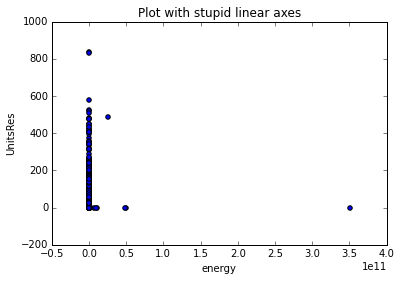

In [18]:
bsize.plot(x='energy', y='UnitsRes', kind='scatter')
plt.title('Plot with stupid linear axes')

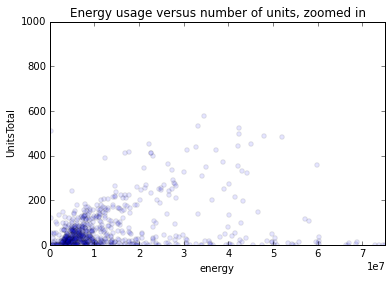

In [20]:
pl.figure()
bsize.plot(x='energy', y='UnitsTotal', kind='scatter', alpha=0.1)
pl.xlim(1000,.75e8)
pl.ylim(1,)
plt.title('Energy usage versus number of units, zoomed in')

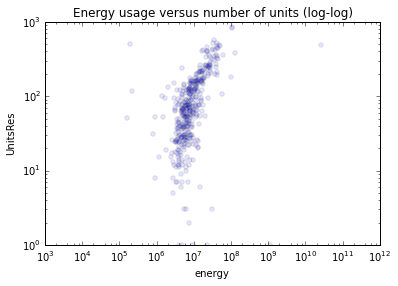

In [21]:
pl.figure()
bsize.plot(x='energy', y='UnitsRes', kind='scatter', alpha=0.1, loglog=True)
pl.xlim(1000,)
pl.ylim(1,)
plt.title('Energy usage versus number of units (log-log)')

In [22]:
max(bsize.UnitsTotal)

842

I don't have any points with 8000 units; maybe the online data set is a little different?

when the points in a plot all look scrunched against the axis try a log plot! in pandas you enable that with the keyword 'loglog' :
bblnrgdata.plot(..... loglog=True)

NOTICE THAT YOU WILL STILL HAVE TO CUT YOUR DATASET! in my data i had a lot of energy datapoints that were exactly 0. I removed these "outliers" which I think are truly outliers in the sense that they are misreported numbers. you can remove the data that have nrg==0 (or nrg < some sensible threshold choice) by indexing your array:
something like bblnrgdata_cut = bblnrgdata[bblnrgdata.nrg>1000]

also i removed the buildings with several thousand units. points like that at the edge of my range would have a lot of "LEVERAGE", however  they are not suprious entries like the 0, which i believe are missing values, or perhaps abandoned lots. these are good datapoint that i need to throw away functionally for my analysis to work, but that should be stated clearly.


Now fit a line through the data. you can use whatever you want to do it: 
statsmodels, scipy, any other package, or write your own minimization of the residuals
## BUT REMEMBER: we see hints of a lienar relation in log space! so we want to fit a line to the log of our variables, not the variables themselves:

if you used statsmodels it would look something like this:

In [23]:
import statsmodels.api as sm

In [24]:
energybblcut = bsize[(bsize.energy > 10) & (bsize.UnitsTotal > 1) & (bsize.energy < 1e9)]

In [26]:
UNITS = sm.add_constant(np.log10(energybblcut.UnitsTotal))
#print X
model = sm.OLS(np.log10(energybblcut.energy), UNITS, missing='drop').fit() # ignores entires where x or y is NaN

In [27]:
#fit = model.fit()
print model.params[1], model.params[0] # could also return stderr in each via fit.bse
print model.summary()

0.128564472389 6.80829104666
                            OLS Regression Results                            
Dep. Variable:                 energy   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     16.22
Date:                Mon, 19 Oct 2015   Prob (F-statistic):           6.30e-05
Time:                        01:27:54   Log-Likelihood:                -415.56
No. Observations:                 650   AIC:                             835.1
Df Residuals:                     648   BIC:                             844.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.8083  

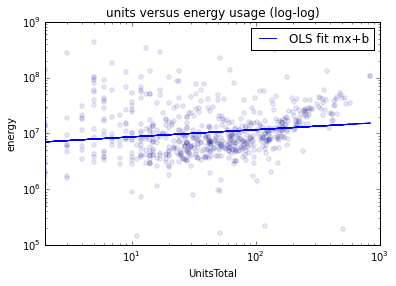

In [29]:
pl.figure()
energybblcut.plot(x='UnitsTotal', y='energy', kind='scatter', alpha=0.1, loglog=True)
pl.plot(energybblcut.UnitsTotal, 10**model.predict(UNITS), '-', label='OLS fit mx+b')
#pl.loglog(np.multiply(energy, sqft), bsize.UnitsRes[mymask_Tot], 'bo', alpha=.1)
pl.xlim(2,)
pl.ylim(1e5,)
plt.legend()
plt.title('units versus energy usage (log-log)')

remember to choose wisely which is your DEPENDENT and which is your INDEPENDENT variable. 
both for what you want to do logically (what changes as a functino of what) but also based on which  variable has a 'sensible' distribution that allows you to fit a function to it: 
    you need your independent variable to span a large range, and to be spread somewhat evenly in the range, 
    rather than just clustered in a spot
    


In [30]:
ENERGY = sm.add_constant(np.log10(energybblcut.energy))
model2 = sm.OLS(np.log10(energybblcut.UnitsTotal), ENERGY, missing='drop').fit() # ignores entires where x or y is NaN
print model2.summary()

                            OLS Regression Results                            
Dep. Variable:             UnitsTotal   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     16.22
Date:                Mon, 19 Oct 2015   Prob (F-statistic):           6.30e-05
Time:                        01:29:57   Log-Likelihood:                -542.47
No. Observations:                 650   AIC:                             1089.
Df Residuals:                     648   BIC:                             1098.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.2677      0.332      0.807      0.4

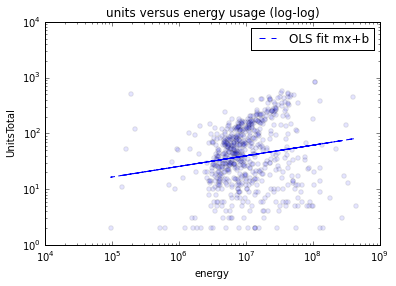

In [31]:
pl.figure()
energybblcut.plot(x='energy', y='UnitsTotal', kind='scatter', alpha=0.1, loglog=True)
pl.plot(energybblcut.energy, 10**model2.predict(ENERGY), '--', label='OLS fit mx+b')
#pl.loglog(np.multiply(energy, sqft), bsize.UnitsRes[mymask_Tot], 'bo', alpha=.1)
pl.xlim(10000,)
pl.ylim(1,)
plt.legend()
plt.title('units versus energy usage (log-log)')

try making a fit for energy vs units AND a fit for units vs energy. 
tell me which is better. 

##look at the fit summary: which is better? could you do a likelihood ratio test here? why or why not??

Since both fits are on a line, they have the same number of parameters and thus the same degrees of freedom. Since the log-likelihood test needs a chi-square disrtibution with df = df2-df1, it does not seem that we can use the test.

Both models have similar R^2, but intuitively we know that energy is a function of units, not the other way around.

##### now fit a second degree curve to it: a*x^2+b*x+c. 
that is still called a linear fir by the way, the "linear" definition refers to the PARAMETERS being linear, not to the variable!
you can use np.polyfit for example (an example showned in the other assignment notebook), with order 2 instead of 1,

np.polyfit(x, y, 2)

or statmodels.formula.api passing a formula like 

formula = 'y ~ 1 + x + I(x ^ 2.0)'

##look at the fit summary: which is better? could you do a likelihood ratio test here? why or why not??

In [32]:
model3 = sm.OLS.from_formula(formula='energy ~ 1 + UnitsTotal + I(UnitsTotal**2)', 
                             data=energybblcut, missing='drop').fit() # ignores entires where x or y is NaN
print model3.summary()
print model3.params

                            OLS Regression Results                            
Dep. Variable:                 energy   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     13.80
Date:                Mon, 19 Oct 2015   Prob (F-statistic):           1.35e-06
Time:                        01:31:04   Log-Likelihood:                -12276.
No. Observations:                 650   AIC:                         2.456e+04
Df Residuals:                     647   BIC:                         2.457e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept           2.032e+07   2.25

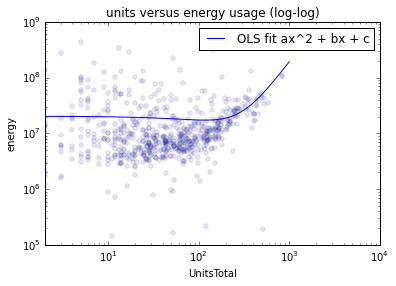

In [34]:
pl.figure()
energybblcut.plot(x='UnitsTotal', y='energy', kind='scatter', alpha=0.1, loglog=True)
myline = [np.dot(model3.params, [1, x, x**2]) for x in arange(1,1000)]
pl.plot(arange(1,1000), myline, '-', label='OLS fit ax^2 + bx + c')
#pl.loglog(np.multiply(energy, sqft), bsize.UnitsRes[mymask_Tot], 'bo', alpha=.1)
pl.xlim(2,)
pl.ylim(1e5,)
plt.legend()
plt.title('units versus energy usage (log-log)')

EXTRA CREDIT: 
    
use WLS the weighted sq fit instead of OLS. you need to give weights to your points: 
estimates of the errors. the easiest thing is the sqrt of the datapoint value.
if you want to be more sophisticated you can estimate the variance of your data
near each point and use that 

In [ ]:
UNITS = sm.add_constant(np.log10(energybblcut.UnitsTotal))
#print X
model4 = sm.WLS(np.log10(energybblcut.energy), UNITS, missing='drop').fit() # ignores entires where x or y is NaN

Lastly: do it by hand and create a function that minimizes the residuals: 
       
the residuals are the sum of the differences between data and model: 
in the case of a line fit model (and you can use your errors if you did the extra credit!)

sum(np.log(bblnrgdatacut.nrg) - np.log(bblnrgdatacut.UnitsTotal)*a+b )^2

where a and b are the parameters returned by the line fitter. 
for each data point you can calculate the model at different values : for example in a range B = np.arange (-100, 100, 1) for the intercept, and A = np.arange(-50.0, 50.0, 0.5) for the slope

write it as a nested for loop (or challenge yourself and vectorize it!) with a loop inside another ranging all poissible combinations of the 2 variables (i use enumerate to get both an index from 0 to the size of my array, which i assign to i (and j) and the value of the array at that index - look up the syntax!):


for i,a in enumerate(A):

    for j,b in enumerate(B):
    
         Lsurface[i][j].....

this gives you a 2D array that represents your likelihood surface! what we do to find a good fit is find the minimum (lowest point) on this surface. 

you can plot a surface (a 2D array) with pl.imshow(Lsurface) as a "heatmap"

but when you do that you will find that the plot is very uninformative. just like you did before with the data, plot the log of it (pl.imshow(np.log(Lsurface))
and see if it helps!
also make sure your x and y axes tick numbers represent the range of values, not the cell index, which is the default for imshow. do that with the keyword extent: 
pl.imshow(Lsurface, .... , extent = [minimum, and max of your y array, minimum, and max of your x array]...) (notice that the numbers are switched! make sure to verify which axis is the slope, which is the intercept)

In [ ]:
log_Energy = np.log(energybblcut.energy)
log_Units = np.log(energybblcut.UnitsTotal)

A = np.arange(-50, 50, .5)
B = np.arange(-100, 100, 1)
Lsurface = np.zeros((len(A), len(B)))

for i,a in enumerate(A):
    for j,b in enumerate(B):
        Lsurface[i][j] = np.sum((log_Energy - log_Units*a+b)**2)
        

<matplotlib.colorbar.Colorbar instance at 0x7f4aa0265fc8>

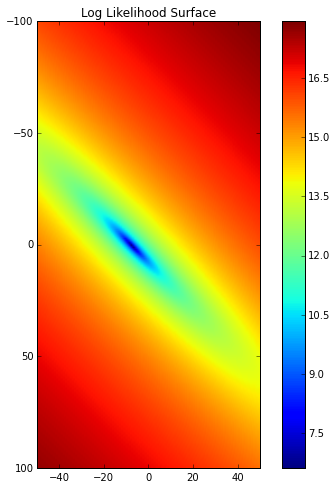

In [40]:
pl.figure(figsize=(8,8))
pl.title ("Log Likelihood Surface")
pl.imshow(np.log(Lsurface), extent=[-50,50,100,-100])
pl.colorbar()

EXTRA CREDIT: get creative with the dataset! can you make an insigntful plot to show any structure in the data?
    
below is my silly attempt at that




In [ ]:
bblnrgdatacut['YearBuilt'][bblnrgdatacut['YearBuilt']<1800]=1800

bblnrgdatacut.plot(kind='scatter',x='nrg',y='UnitsTotal', fontsize=22, colormap='gist_rainbow', alpha = 1, marker='o',  figsize=(16, 14), loglog=True,  xlim=(1000,1e11), ylim=(1,1000), c=bblnrgdatacut['YearBuilt']-1900, s=bblnrgdatacut['UnitsTotal']/bblnrgdatacut['UnitsRes']*100)